In [2]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [3]:
dataset=pd.read_csv("dataset.csv",sep=";")
dataset.drop(["node"],inplace=True,axis=1)
dataset["date"]=pd.to_datetime(dataset["date"],format="%Y-%m-%d %H:%M:%S")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242968 entries, 0 to 2242967
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   consumption  float64       
 1   substation   object        
 2   date         datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 51.3+ MB


In [4]:
train=dataset.query("date.dt.year>2017 and date.dt.year <2022")
train=train.set_index("date")

In [5]:
test=dataset.query("date.dt.year==2022")
test=test.set_index("date")

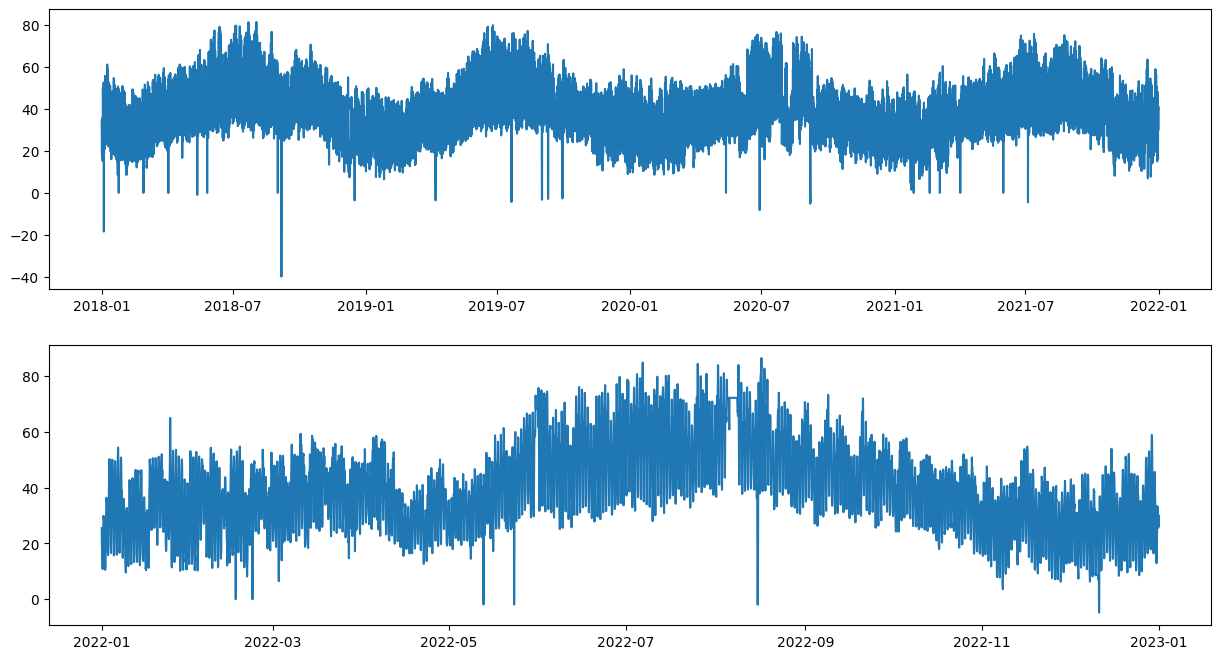

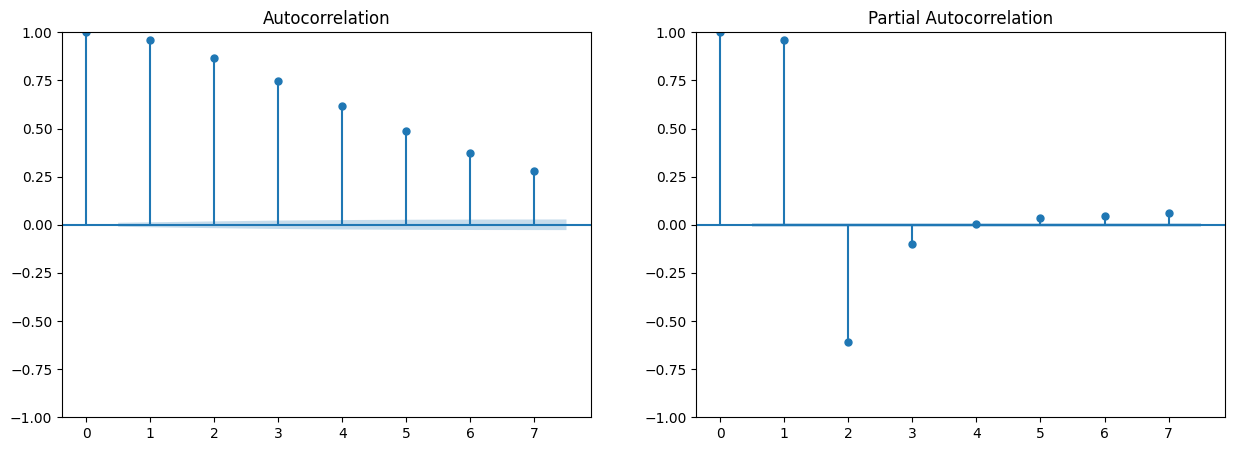

In [6]:
subestacion="AJAHUEL"
filtro="substation=='{0}'".format(subestacion)
ds_train=train.query(filtro)["consumption"].groupby("date").aggregate(consumption="mean")
ym=ds_train["consumption"].to_numpy()
xm=ds_train.index.to_numpy()
filtro="substation=='{0}'".format(subestacion)
ds_test=test.query(filtro)["consumption"].groupby("date").aggregate(consumption="mean")
ytm=ds_test["consumption"].to_numpy()
xtm=ds_test.index.to_numpy()
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(xm,ym);
axes[1].plot(xtm,ytm);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ym,lags=7,ax=axes[0]);
plot_pacf(ym,lags=7,method="ywm",ax=axes[1]);


In [7]:
deltas = 365*24*4
start = datetime.datetime.strptime("2018-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
train_full = [start + datetime.timedelta(hours=x) for x in range(deltas)]
deltas = 365*24
start = datetime.datetime.strptime("2022-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
test_full = [start + datetime.timedelta(hours=x) for x in range(deltas)]
missing_train=[]
missing_test=[]
for fecha in train_full:
    if not (fecha in ds_train.index):
        missing_train.append(fecha)
missing_test=[]
for fecha in test_full:
    if not (fecha in ds_test.index): 
        missing_test.append(fecha)
print(len(train_full),len(ds_train),len(missing_train),
      len(test_full),len(ds_test),len(missing_test))
print(missing_test[0].strftime('%Y-%m-%d %H:%M:%S'))

35040 34913 151 8760 8759 1
2022-09-11 00:00:00


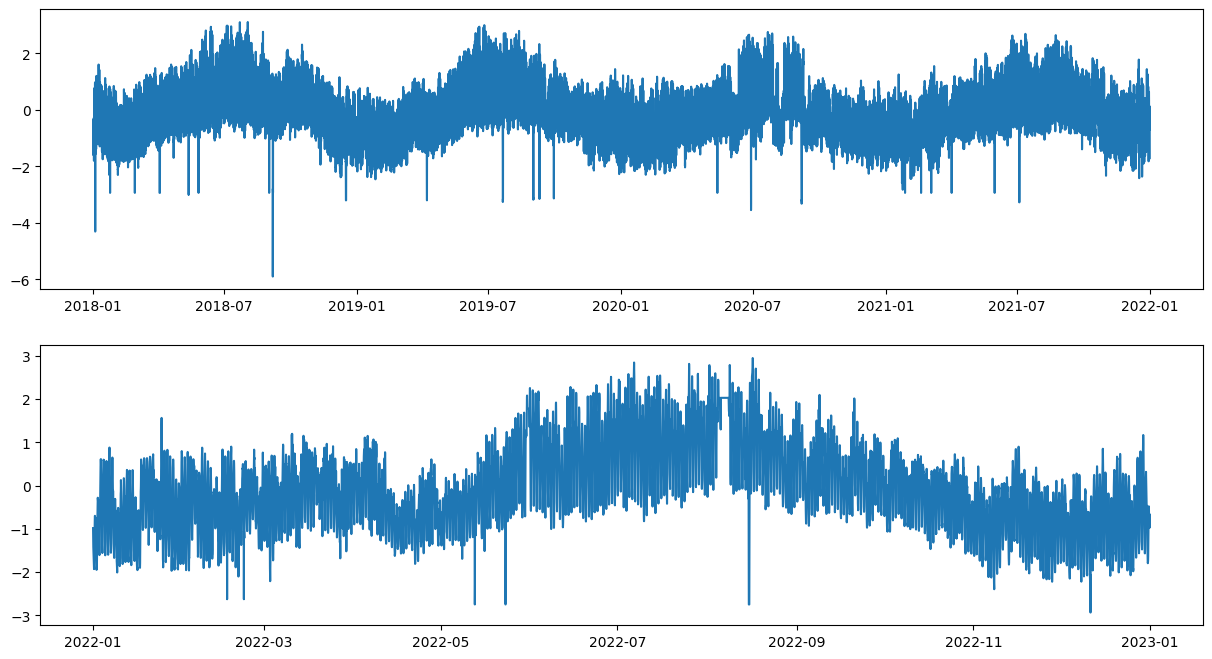

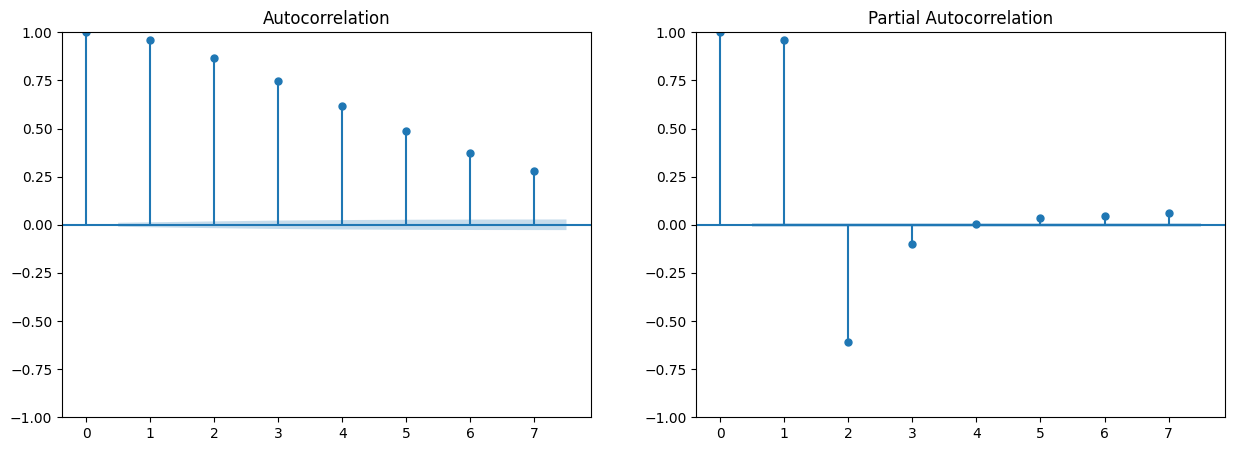

In [8]:
scaler = StandardScaler()
ym=ym.reshape(-1,1)
scaler.fit(ym)
ym_z=scaler.transform(ym)
ytm=ytm.reshape(-1,1)
scaler.fit(ytm)
ytm_z=scaler.transform(ytm)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(xm,ym_z);
axes[1].plot(xtm,ytm_z);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ym_z,lags=7,ax=axes[0]);
plot_pacf(ym_z,lags=7,method="ywm",ax=axes[1]);

In [9]:
result = adfuller(ym)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.320034
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [10]:
modelo_ajahuel_d=ARIMA(ym,order=(2,0,2))
m_ad1=modelo_ajahuel_d.fit()
print("MSE",m_ad1.mse)
print("AIC",m_ad1.aic)
ymp=m_ad1.predict()
ytmp=m_ad1.forecast(7*24)

MSE 9.259223597603505
AIC 176794.16793839508


39.42311119909847 1.8179814129312508 0.04611461038044162


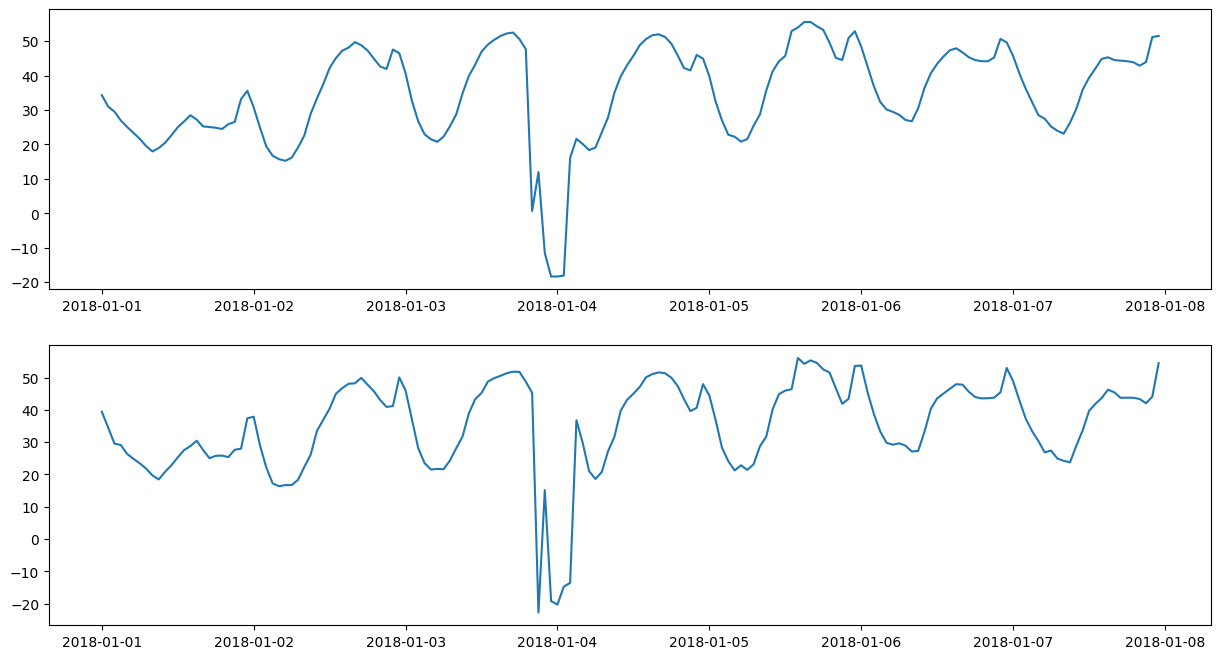

In [11]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(xm[:7*24],ym[:7*24]);
axes[1].plot(xm[:7*24],ymp[:7*24]);
media=np.mean(ym)
error=mean_absolute_error(ym,ymp)
print(media,error,error/media)

31.583435941964282 11.529806612284892 0.36505865395618553


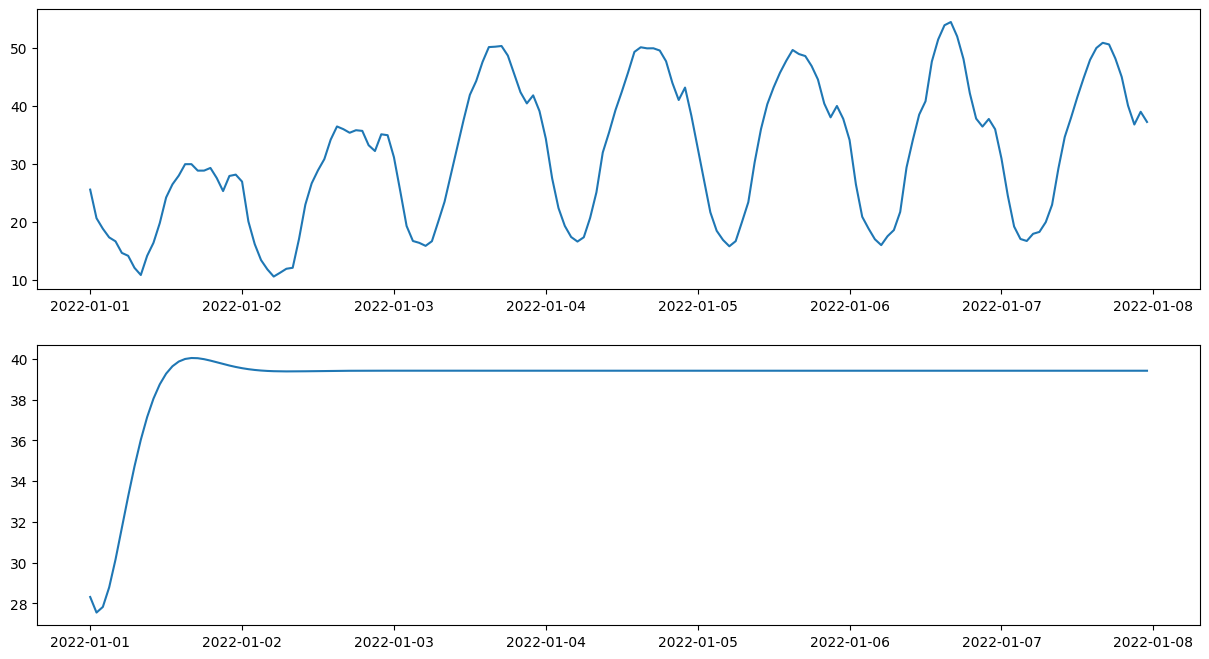

In [12]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(xtm[:7*24],ytm[:7*24]);
axes[1].plot(xtm[:7*24],ytmp);
media=np.mean(ytm[:7*24])
error=mean_absolute_error(ytm[:7*24],ytmp)
print(media,error,error/media)

In [13]:
yw=[]
yt=[]
window=2
for i in range(0,len(ym)):
    if i+window < len(ym):
        row=[]
        for j in range(window):
            row.append(ym[i+j])
        yw.append(row)
        yt.append(ym[i+window])
    else:
        break
print(len(yw))
yw=np.asarray(yw)
yt=np.asarray(yt)

34911


In [14]:
yw_test=[]
yt_test=[]
window=2
for i in range(0,len(ytm)):
    if i+window < len(ytm):
        row=[]
        for j in range(window):
            row.append(ytm[i+j])
        yw_test.append(row)
        yt_test.append(ytm[i+window])
    else:
        break
print(len(yw_test))
yw_test=np.asarray(yw_test)
yt_test=np.asarray(yt_test)

8757


In [15]:
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from keras.layers import SimpleRNN, Input, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random as rd

2024-04-28 23:30:07.574473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
seed=12122008
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
model = Sequential()
model.add(Input(name="serie",shape=(2,1)))
model.add(SimpleRNN(256))
model.add(Dense(128))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 256)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,073 (387.00 KB)

 Trainable params: 99,073 (387.00 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

model.compile(optimizer="Adam", loss='huber', metrics=['mse','mae'])
rnn = model.fit(yw, yt, validation_data=(yw_test,yt_test),
                batch_size=256, epochs=64,shuffle=True,verbose=1,callbacks=[tensorboard_callback])
model.save(log_dir+'/model_{0}.keras'.format(tag))

Epoch 1/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.7417 - mae: 10.2140 - mse: 280.0044 - val_loss: 1.6479 - val_mae: 2.0792 - val_mse: 10.5412
Epoch 2/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4696 - mae: 1.8958 - mse: 8.7650 - val_loss: 1.5066 - val_mae: 1.9334 - val_mse: 9.5895
Epoch 3/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4073 - mae: 1.8319 - mse: 8.2659 - val_loss: 1.4854 - val_mae: 1.9132 - val_mse: 9.4203
Epoch 4/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3783 - mae: 1.8015 - mse: 8.0990 - val_loss: 1.4702 - val_mae: 1.8977 - val_mse: 9.3313
Epoch 5/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3696 - mae: 1.7925 - mse: 8.0391 - val_loss: 1.4607 - val_mae: 1.8879 - val_mse: 9.2771
Epoch 6/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3629 - mae: 1.7854 - mse: 7.9943 - val_loss: 1.4519 - val_mae: 1.8790 - val_mse: 9.2287
Epoch 7/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3565 - mae: 1.7787 - mse: 7.9536 -

1091/1091 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
39.42349795757426 1.6349704442947932 0.04147197810945828


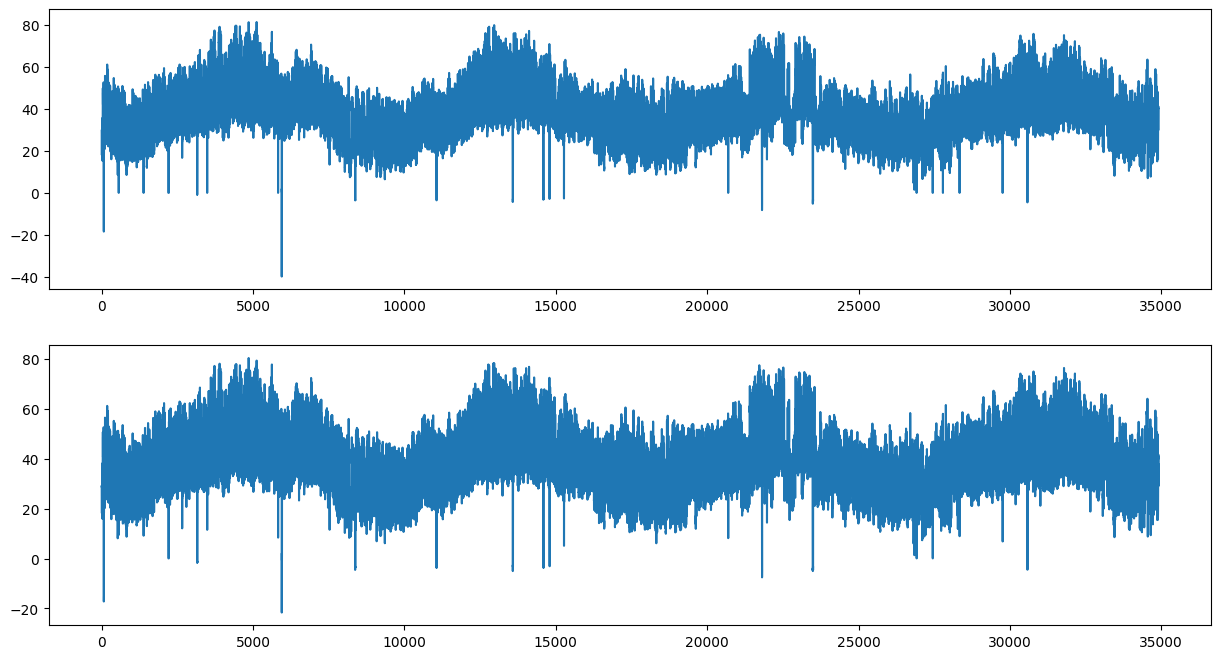

In [18]:
yp=model.predict(yw)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(yt);
axes[1].plot(yp);
media=np.mean(yt)
error=mean_absolute_error(yt,yp)
print(media,error,error/media)

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
40.74086975028549 1.7578244768727274 0.0431464641684634


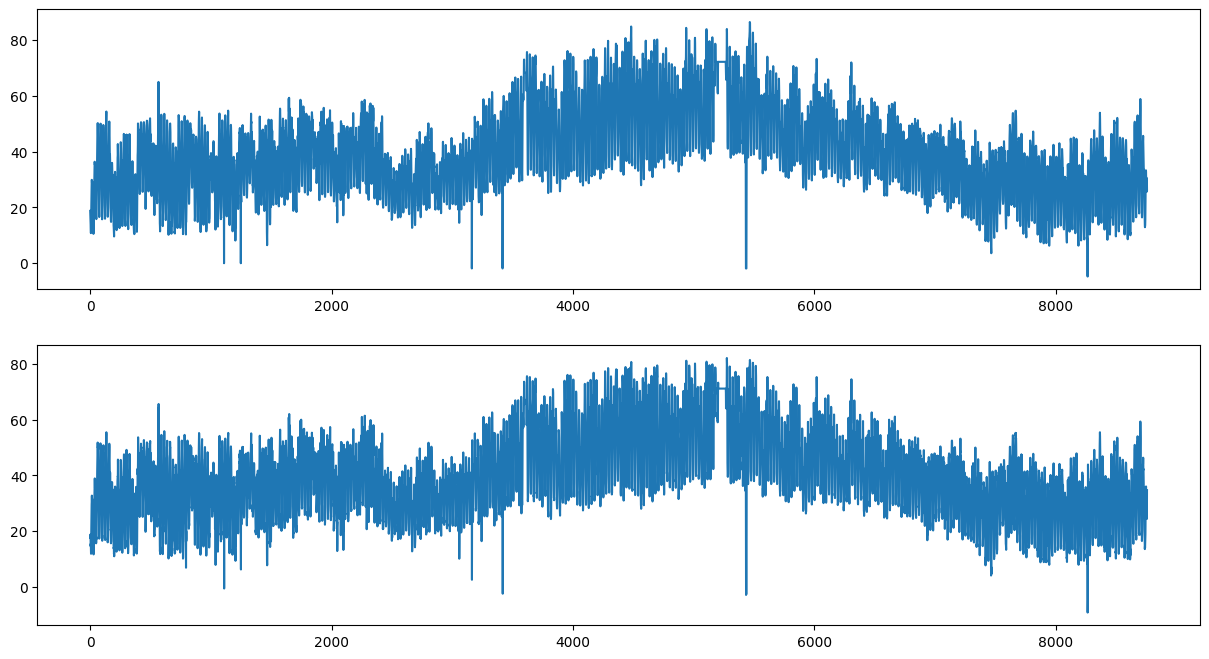

In [19]:
yp_test=model.predict(yw_test)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(yt_test);
axes[1].plot(yp_test);
media=np.mean(yt_test)
error=mean_absolute_error(yt_test,yp_test)
print(media,error,error/media)

31.674065425595234 13.521995451121013 0.42691063712314414


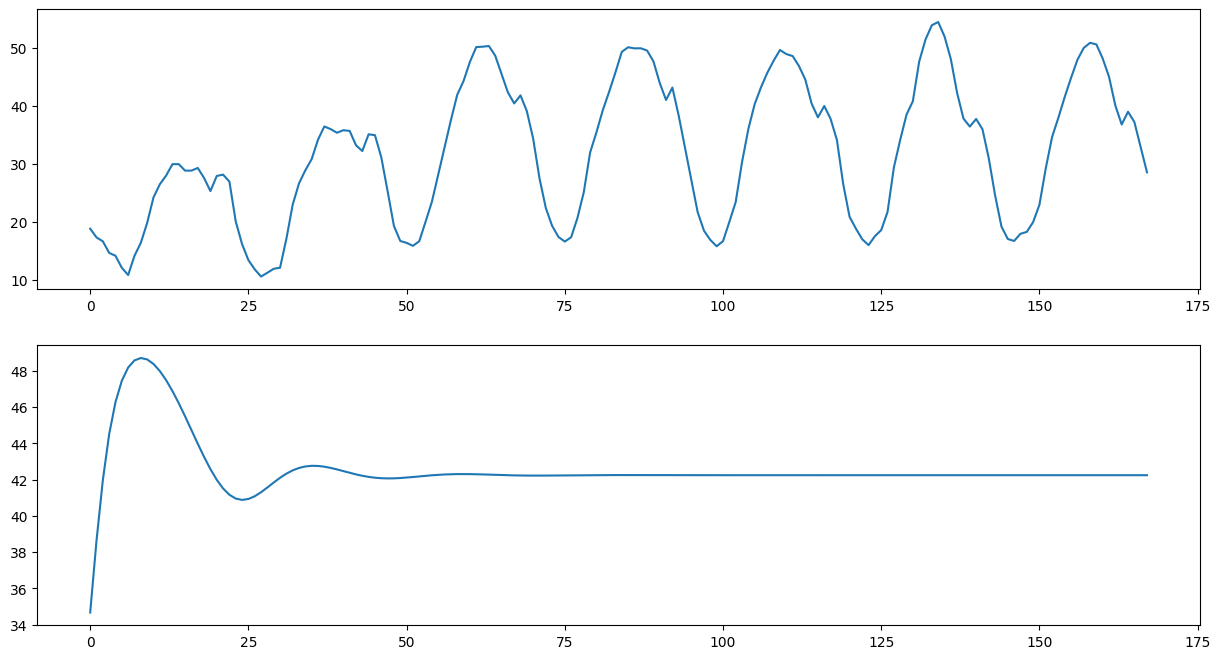

In [20]:
ultimo=yw_test[-1].copy().reshape(1,2,1)
forecasts=[]
horizonte=7*24
for i in range(horizonte):
    forecast=model.predict(ultimo,verbose=0);
    valor=forecast.reshape(1)[0]
    forecasts.append(valor)
    lista=ultimo.reshape(1,2)[0].tolist()
    lista.pop(0)
    lista.append(valor)
    siguiente=np.asarray(lista).reshape(1,2,1)
    ultimo=siguiente
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(yt_test[:horizonte]);
axes[1].plot(forecasts);
media=np.mean(yt_test[:horizonte])
error=mean_absolute_error(yt_test[:horizonte],forecasts)
print(media,error,error/media)

In [21]:
yw=[]
yt=[]
window=168
for i in range(0,len(ym)):
    if i+window < len(ym):
        row=[]
        for j in range(48):
            row.append(ym[i+j])
        yw.append(row)
        row=[]
        for j in range(120):
            row.append(ym[i+48+j])
        yt.append(row)
    else:
        break
print(len(yw))
yw=np.asarray(yw)
yt=np.asarray(yt)

34745


In [22]:
yw_test=[]
yt_test=[]
window=168
for i in range(0,len(ytm)):
    if i+window < len(ytm):
        row=[]
        for j in range(48):
            row.append(ytm[i+j])
        yw_test.append(row)
        row=[]
        for j in range(120):
            row.append(ytm[i+48+j])
        yt_test.append(row)
    else:
        break
print(len(yw_test))
yw_test=np.asarray(yw_test)
yt_test=np.asarray(yt_test)

8591


In [23]:
seed=12122008
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
model = Sequential()
model.add(Input(name="serie",shape=(48,1)))
model.add(SimpleRNN(256))
model.add(Dense(128))
model.add(Dense(120, activation='linear'))
tag="mrnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-4)

model.compile(optimizer="Adam", loss='huber', metrics=['mse','mae'])
rnn = model.fit(yw, yt, validation_data=(yw_test,yt_test),
                batch_size=256, epochs=64,shuffle=True,verbose=1,callbacks=[tensorboard_callback])
model.save(log_dir+'/model_{0}.keras'.format(tag))

Epoch 1/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 21.6166 - mae: 22.1117 - mse: 749.6520 - val_loss: 11.7168 - val_mae: 12.2073 - val_mse: 237.7615
Epoch 2/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 10.1764 - mae: 10.6672 - mse: 174.1355 - val_loss: 11.0871 - val_mae: 11.5772 - val_mse: 211.3305
Epoch 3/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 9.6455 - mae: 10.1359 - mse: 156.2802 - val_loss: 9.9878 - val_mae: 10.4773 - val_mse: 175.8916
Epoch 4/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 9.0746 - mae: 9.5639 - mse: 143.5915 - val_loss: 9.8697 - val_mae: 10.3585 - val_mse: 176.5453
Epoch 5/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 8.8709 - mae: 9.3596 - mse: 139.5523 - val_loss: 8.9653 - val_mae: 9.4532 - val_mse: 147.3221
Epoch 6/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 7.7575 - mae: 8.2441 - mse: 111.5070 - val_loss: 7.7290 - val_mae: 8.2146 - val_mse: 117.7094
Epoch 7/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss

In [24]:
ultimo=yw_test[-1].reshape(1,48,1)
ultimo.shape

(1, 48, 1)

34.69024644791667 5.809530522479757 0.16746870135967712


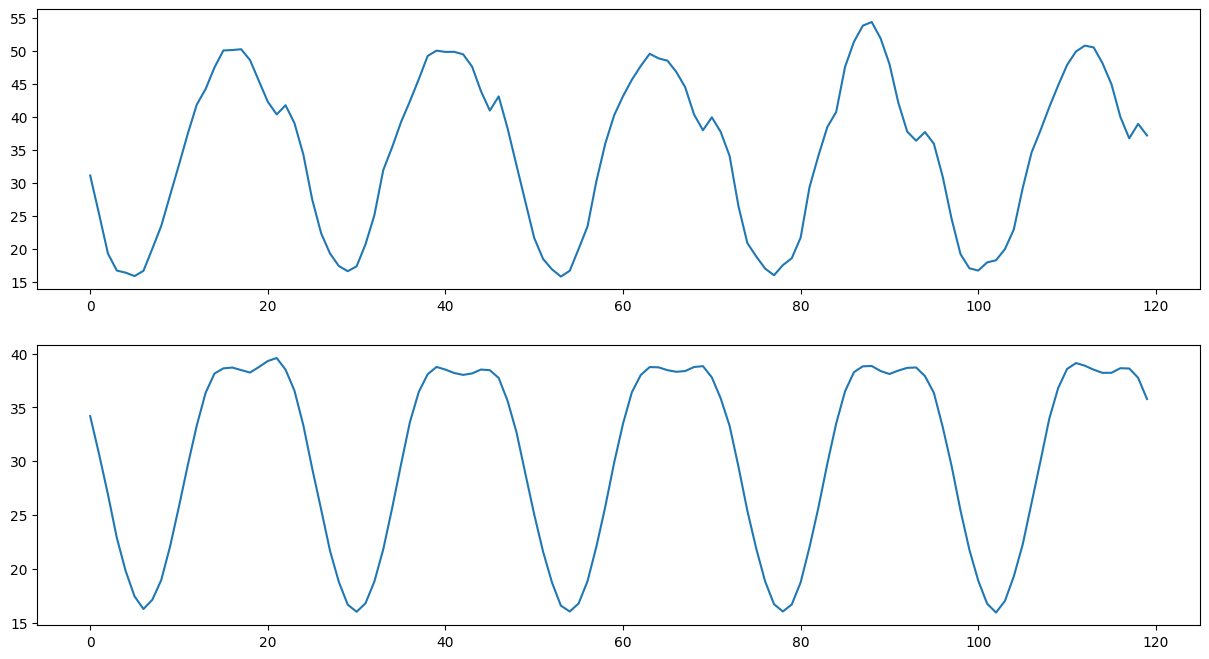

In [26]:
forecast=model.predict(ultimo,verbose=0)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
real=yt_test[0].tolist()
pred=forecast[0].tolist()
axes[0].plot(real);
axes[1].plot(pred);
media=np.mean(real)
error=mean_absolute_error(real,pred)
print(media,error,error/media)